In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from ipywidgets import interact, widgets
from IPython.display import display
import scipy.linalg
from IPython import display
import pywt
from skimage import data
import skimage

import pdb

#  Proximal gradient methods for LASSO 

In previous notebooks, we used the projected gradient method. Although the algorithm was successful, it required many iterations and lengthy computation time. Here, we switch to proximal gradient methods. Recall, the Lasso formulation is given by:

$$\min_{\boldsymbol x} \frac{1}{2} \|\boldsymbol y- \boldsymbol A \boldsymbol x\|_2^2 + \lambda \|\boldsymbol x\|_1 $$

Given $\boldsymbol y \in R^m$, $\boldsymbol A\in R^{mxn}$ and $\boldsymbol x \in R^n$ 

The Proximal Gradient Method for Lasso (also called the Iterative Shrinkage Thresholding Algorithm (ISTA)) is given by: 

__Input:__ $\boldsymbol x_0 \in R^n$ and $L \geq \lambda_{max}(\boldsymbol A^* \boldsymbol A)$ <br>
__while__ $\boldsymbol x_k$ not converged (k=1,2, ...) __do__ <br>
> $\boldsymbol w_k \leftarrow x_k - \frac{1}{L}\boldsymbol A^* (\boldsymbol A \boldsymbol x_k -\boldsymbol y)$ <br>
$\boldsymbol x_{k+1} \leftarrow $ soft$(\boldsymbol w_k, \lambda/L)$ 

__end while__ <br>
__Output: $\boldsymbol x_* \leftarrow \boldsymbol x_k$__

In [6]:
def soft(w,t):
    wnew = np.zeros(len(w))
    for kk in range(len(w)):
        wnew[kk] = np.sign(w[kk])*np.max([np.abs(w[kk])-t,0])
    return wnew

def ista(A,y,lam, x0,L,tol):
    x = [x0]
    At = np.transpose(A)
    isConverged = False
    while (not isConverged):
        w = x[-1] - 1/L *At.dot(A.dot(x[-1])-y)
        xNew = [soft(w, lam/L)] 
        x = np.vstack((x,xNew))

        if np.linalg.norm(x[-1]-x[-2]) <= tol:
            isConverged = True
    return x


An accelerated version of this algorithm, sometimes called the Fast Iterative Shrinkage Thresholding Algorithm (FISTA), is shown below: 


__Input:__ $\boldsymbol x_0 \in R^n$, $\boldsymbol p_1 \leftarrow \boldsymbol x_0$, $t_1 \leftarrow 1 $and $L \geq \lambda_{max}(\boldsymbol A^* \boldsymbol A)$ <br>
__while__ $\boldsymbol x_k$ not converged (k=1,2, ...) __do__ <br>
> $\boldsymbol w_k \leftarrow \boldsymbol p_k -\frac{1}{L} \boldsymbol A^*(\boldsymbol A \boldsymbol p_k -y)$ <br>
$\boldsymbol x_{k+1} \leftarrow $ soft$(\boldsymbol w_k, \lambda/L)$ <br>
$t_{k+1} \leftarrow \frac{1+\sqrt{1+4t_k^2}}{2}; \beta_{k+1} \leftarrow \frac{t_{k}-1}{t_{k+1}}$ <br>
$\boldsymbol p_{k+1} \leftarrow \boldsymbol x_{k+1} + \beta_{k+1} (\boldsymbol x_{k+1} - \boldsymbol x_k)$


__end while__ <br>
__Output: $\boldsymbol x_* \leftarrow \boldsymbol x_k$__

In [7]:
def fista(A,y,lam, x0,L,tol):
    x = [x0]
    p = [x0]
    tOld = 1
    At = np.transpose(A)
    isConverged = False
    while (not isConverged):
        w = p[-1] - 1/L *At.dot(A.dot(p[-1])-y)
        xNew = [soft(w, lam/L)]
        x = np.vstack((x,xNew))
        tNew = (1+np.sqrt(1+4*tOld**2))/2
        beta = (tOld-1)/tNew
        pNew = x[-1] + beta*(x[-1]-x[-2])
        p = np.vstack((p,pNew))
        tOld = tNew
        if np.linalg.norm(x[-1]-x[-2]) <= tol:
            isConverged = True
    return x 


And we have the projected subgradient method from previous notebooks.

In [8]:
def pgd(A,y,x0, tol):
    m = A.shape[0]
    n = A.shape[1]
    At = np.transpose(A)
    AAt = np.matmul(A,At)
    AtinvAAt = np.matmul(At,np.linalg.pinv(AAt))
    P = np.identity(n) - np.matmul(AtinvAAt,A)
    xTilde = AtinvAAt.dot(y)
    f = np.array([np.linalg.norm(x0, ord=1)])
    x= np.array([x0])
    t=0
    isConverged = False
    while (not isConverged):
        t = t+1
        xNew = np.array([xTilde + P.dot(x[-1] - 1/t* np.sign(x[-1]))])
        x = np.vstack((x,xNew))
        f = np.vstack((f,np.linalg.norm(x[-1],ord=1)))
        if np.linalg.norm(x[-1]-x[-2]) <= tol:
            isConverged = True
    return x

First we compare the convergence of the three methods (projected subgradient method, ISTA, FISTA, and ALM) on a simulated example with noise. I.e.,  

$$\boldsymbol y = \boldsymbol A \boldsymbol x + \boldsymbol n$$



In [49]:
n = 500 # Matrix size
m = 100
k = 10 # Number of nonzeros
xTrue = np.concatenate((np.random.randn(k),np.zeros(n-k))) # Create sparse vector
xTrue = xTrue[np.random.permutation(n)];
A = np.random.randn(m,n) # Create Matrix A
noise = 2*np.random.randn(m)

y = A.dot(xTrue)+noise

tol = 1e-3
x0 = np.zeros(n)
eigenvalues = np.linalg.eigvalsh(np.matmul(np.transpose(A),A))
L = np.max(eigenvalues)
lam = 40

xPGD = pgd(A,y,x0,tol)
xISTA = ista(A,y,lam,x0,L,tol)
xFISTA = fista(A,y,lam,x0,L,tol)

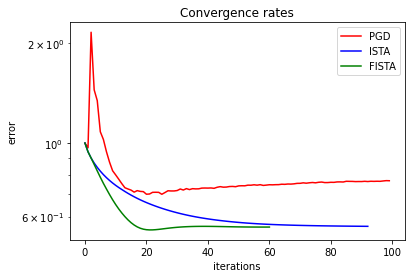

In [50]:
#Plot the recovery error.

error_PGD = np.zeros(xPGD.shape[0])
for ii in range(len(error_PGD)):
    error_PGD[ii] = np.linalg.norm(xPGD[ii]-xTrue) / np.linalg.norm(xTrue)

error_ISTA = np.zeros(xISTA.shape[0])
for ii in range(len(error_ISTA)):
    error_ISTA[ii] = np.linalg.norm(xISTA[ii]-xTrue) / np.linalg.norm(xTrue)

error_FISTA = np.zeros(xFISTA.shape[0])
for ii in range(len(error_FISTA)):
    error_FISTA[ii] = np.linalg.norm(xFISTA[ii]-xTrue) / np.linalg.norm(xTrue)
    
maxiter = 100
plt.semilogy(error_PGD[:maxiter],'r', label='PGD')
plt.semilogy(error_ISTA[:maxiter],'b', label='ISTA')
plt.semilogy(error_FISTA[:maxiter],'g', label='FISTA')
plt.title('Convergence rates')
plt.xlabel('iterations')
plt.ylabel('error')
plt.legend()
plt.show()

On this example, the projected gradient descent is the slowest to converge. It also convergest to a result with higher error, likely due to the added noise in the problem setup.

While ISTA and FISTA converge faster to a result with lower error, they both require careful tuning of the $\lambda$ (and possibly the $L$ parameter) in order to get good results.

In all cases, noise prevents perfect recovery. 

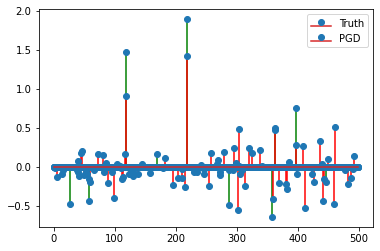

In [53]:
#Recovery of PGD
plt.stem(range(n), xTrue, 'g', label='Truth')
plt.stem(range(n), xPGD[-1], 'r', label='PGD')
plt.legend()
plt.show()

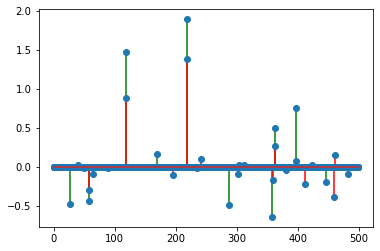

In [51]:
#Recovery of FISTA
plt.stem(range(n), xTrue, 'g')
plt.stem(range(n), xFISTA[-1], 'r')
plt.show()